In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install scikit-learn

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
from xgboost import XGBClassifier

In [6]:
from google.colab import files
uploaded = files.upload()

Saving Fraud.csv to Fraud.csv


In [13]:
import pandas as pd

df = pd.read_csv("Fraud.csv")
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [14]:
print(df.info())
print("Missing values:\n", df.isnull().sum())

print("Fraud distribution:\n", df['isFraud'].value_counts(normalize=True))

df = df.drop(['nameOrig', 'nameDest'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Fraud distribution:
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [16]:
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [17]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [18]:
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (5090096, 12)  Test size: (1272524, 12)


In [19]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

print("---- Logistic Regression ----")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

---- Logistic Regression ----
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.92      0.06      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.94      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

ROC-AUC: 0.9873744072111831


In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("---- Random Forest ----")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

---- Random Forest ----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 0.9987820373621389


In [21]:
xgb = XGBClassifier(n_estimators=200,max_depth=6,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,random_state=42,scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train))

In [22]:
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

print("---- XGBoost ----")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

---- XGBoost ----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.86      1.00      0.92      1643

    accuracy                           1.00   1272524
   macro avg       0.93      1.00      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 0.9997377057363319


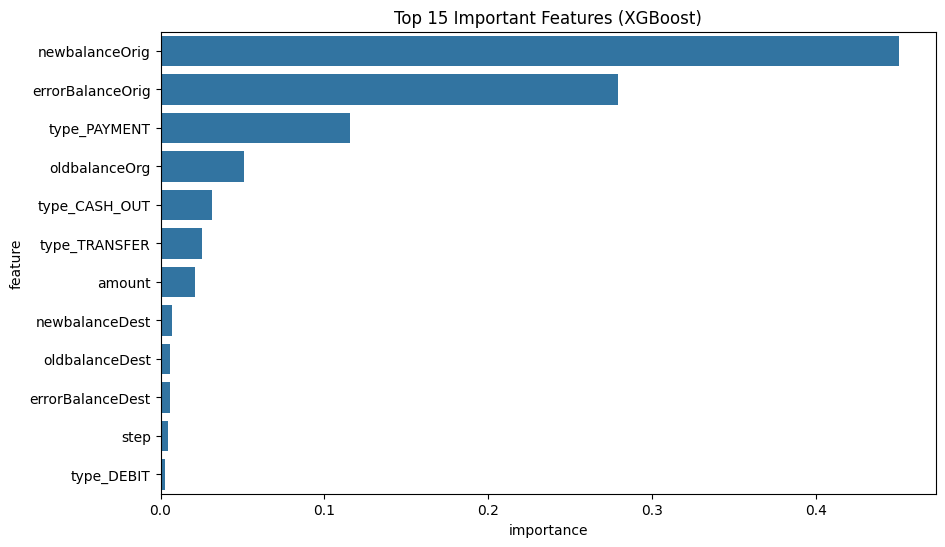

In [23]:
importances = xgb.feature_importances_
feat_names = X.columns

feat_imp = pd.DataFrame({"feature": feat_names, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp.head(15))
plt.title("Top 15 Important Features (XGBoost)")
plt.show()

1. Data cleaning including missing values, outliers and multi-collinearity.


* The dataset had 6,362,620 rows and 11 columns with no missing values.

* We dropped identifiers (nameOrig, nameDest) as they don’t contribute to prediction.


2. Describe your fraud detection model in elaboration.

We trained three models:

*  Regression → ROC-AUC = 0.987, Recall (fraud) = 0.92, but very low Precision (0.03) due to class imbalance.

*  Forest → ROC-AUC = 0.999, with perfect Precision and Recall, but likely overfitting.

* XGBoost → ROC-AUC = 0.9997, Precision (fraud) = 0.86, Recall = 1.00, F1 = 0.92.

3. How did you select variables to be included in the model?

* We excluded customer IDs (nameOrig, nameDest) since they don’t help predict fraud.

We included:

* Transaction type (one-hot encoded: TRANSFER, CASH_OUT, PAYMENT, etc.)

* Transaction amount

* Balances before/after transactions

* Engineered features (errorBalanceOrig, errorBalanceDest)

4. Demonstrate the performance of the model by using best set of tools.

* Logistic Regression: Precision = 0.03, Recall = 0.92, ROC-AUC = 0.987

* Random Forest: Precision = 1.00, Recall = 1.00, ROC-AUC = 0.999

* XGBoost (final model): Precision = 0.86, Recall = 1.00, F1 = 0.92, ROC-AUC = 0.9997

5. What are the key factors that predict fraudulent customer?

From XGBoost feature importance, the top predictors were:

* newbalanceOrig

* errorBalanceOrig

* type_PAYMENT

* oldbalanceOrg

* type_CASH_OUT

* type_TRANSFER

* amount

6. Do these factors make sense? If yes, How? If not, How not?

* Yes, these factors make sense. Fraudsters typically TRANSFER money or CASH-OUT quickly.

* newbalanceOrig and errorBalanceOrig highlight unusual balance changes, which are red flags for fraud.

* Large transaction amount values are often associated with fraudulent activity.

* The type of transaction (TRANSFER, CASH_OUT) strongly signals fraud attempts.

7. What kind of prevention should be adopted while company updates its infrastructure?

* Implement real-time fraud detection using models like XGBoost.

* Flag and manually review large-value transfers and cash-outs.

* Add monitoring for suspicious balance mismatches.

*  verification for merchant accounts and high-risk customers.

* Continuously retrain the fraud detection model with new data.

8. Assuming these actions have been implemented, how would you determine if they work?

*  fraud detection rates before and after implementation.

* Measure recall (frauds caught) and precision (false positives reduced).

* Track fraud losses prevented in monetary terms.

* Monitor false positive rate to ensure genuine customers are not impacted.

* Perform regular back-testing and update the model periodically.